In [ ]:
#!pip install pyfrc frc3223-azurite
#!pip install robotpy-ctre

In [ ]:
#!conda install -c menpo ffmpeg -y

In [1]:
import numpy
import wpilib
import ctre
from hal_impl.data import hal_data
from matplotlib import pyplot as plt
from frc3223_azurite.motors import *
from frc3223_azurite.conversions import *

from frc3223_azurite.pidcontroller import NoThreadingPIDController as PIDController
from arm import ArmSimulation

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, numpy.degrees(sim.thetas))
    if ylim is None:
        ylim = (-(180), (180))
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (deg)')
    plt.show()
    
def plot_velocity(sim, ylim =None):
    if ylim is None:
        ylim = (-(50), (50))
    plt.plot(sim.ts, numpy.degrees(sim.vs))
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (deg/s)')
    plt.show()
    
def plot_voltages(sim, ylim =None):
    if ylim is None:
        ylim = (-(1.1), (1.10))
    plt.plot(sim.ts, sim.voltages)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('voltage')
    plt.show()

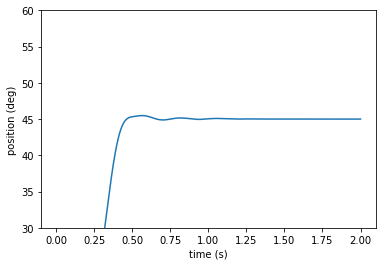

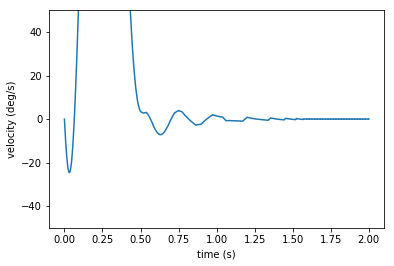

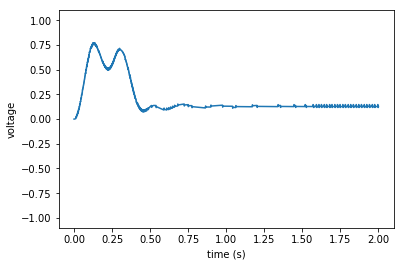

In [29]:

def init(state):
    state.timer = wpilib.Timer()
    state.timer.start()
    state.motor.set(0.0)
    ctre.WPI_TalonSRX.Notifier = None
    talon = ctre.WPI_TalonSRX(1)
    
    talon.selectProfileSlot(0, 0)
    talon.configSelectedFeedbackSensor(talon.FeedbackDevice.QuadEncoder, 0, 0)
    talon.configMotionCruiseVelocity(int(1 * 4096 * 0.1), 0) # 1 rps
    talon.configMotionAcceleration(int(2 * 4096 * 0.1), 0) # 2 rps^2
    talon.configAllowableClosedloopError(0, 50, 0)
    talon.config_kP(0, 10, 0)
    talon.config_kI(0, .15, 0)
    talon.config_kD(0, 10, 0)
    state.talon = talon
    
    state.talon.set(ctre.ControlMode.MotionMagic, int(4096 * 45. / 360))
    
def pid_periodic(state):
    enc_pos = int(state.theta_rad * 4096 / (2 * math.pi))
    enc_vel = int(state.velocity_radps * 4096 / (2 * math.pi))
    hal_data['CAN'][1]['quad_position'] = enc_pos
    hal_data['CAN'][1]['quad_velocity'] = enc_vel
    state.talon._calculate_1ms()
    state.motor.set(state.talon.hal_data['value'])
    #print('tacos!')
    
def periodic(state):
    #"""
    #state.motor.set(1)
    state.talon.set(ctre.ControlMode.MotionMagic, int(4096 * 45. / 360))
    pass
    #print ("th deg:%f, th enc:%f, target: %f, err:%f" % (numpy.degrees(state.theta_rad), int(state.theta_rad * 4096 / (2 * math.pi)), state.talon._target, state.talon._err))

sim = ArmSimulation(
    dt_s=0.0001,
    starting_position_rad=numpy.radians(0),
    end_mass_kg=lbs_to_kg(10),
    arm_mass_kg=lbs_to_kg(.10),
    arm_length_m=inch_to_meter(16),
    pid_sample_rate_s=0.001,
    nominal_voltage=12.,
    damping=0.01,
    periodic = periodic,
    pid_periodic = pid_periodic,
    init = init,
    motor_system=MotorSystem(motor=bag, motor_count=1, gearing_ratio=250),
)
sim.run_sim(timeout=2.)


plot_position(sim, ylim=(30,60))
plot_velocity(sim)
plot_voltages(sim)

In [19]:
numpy.degrees(sim.thetas[-4:
      ])

array([ 45.08611085,  45.0860447 ,  45.08598081,  45.08591917])

In [ ]:
print(list(zip([1,2,3],[4,5,6])))

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#print(matplotlib.projections.projection_registry.get_projection_names())
beta = numpy.zeros(shape=(2,))
radii = numpy.linspace(0, 1, 2)
line, = ax.plot(beta, radii)
dt = sim.dt_s
frame_interval = 50. # ms
speed_factor = 1
n = int(frame_interval / 1000. / dt) # number of data points to skip
L = len(sim.ts) // n # number of data points sampled at n ms
print (n, L, len(sim.ts), dt)
def init():
    return (line,)
def animate(i): 
    #print (i, i*n, numpy.degrees(sim.thetas[i * n]))
    theta = sim.thetas[i * n]
    beta[:] = theta
    line.set_data(beta, radii)
    return (line,)
    

anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval / speed_factor, blit=True)
HTML(anim.to_html5_video())
#fig, ax = plt.subplots(subplot_kw={'projection': 'rectilinear'})

500 20 10498 0.0001


In [ ]:
lbs_to_kg(10) * inch_to_meter(10)

In [ ]:
 math.pi / 2/ rpm_to_radps(93)